### MSEplots functions --- adding ensembles of entrainment and detrainment, internal-gravity  waves
keyword arguments for the ensemble size, and h0 range <br>
fixed: "h4ent = mse" would replace mse as doing h4ent += h0offset, rewriting this part 

<br>
Date: 10/17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import metpy.calc as mpcalc
from metpy.units import units
from metpy.constants import Cp_d,Lv,Rd,g 

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin() # find minimum
    return (idx)

In [102]:
def thermo_plots(pressure,temperature,mixing_ratio):
    """"
    plots for vertical profiles of temperature, dewpoint, mixing ratio and relative humidity.
    
    Parameters
    ----------
    pressure : array-like
            Atmospheric pressure profile (surface to TOA)
    temperature: array-like
            Atmospheric temperature profile (surface to TOA)
    dewpoint: array-like
            Atmospheric dewpoint profile (surface to TOA)    
    Returns
    -------
    """
    q = mixing_ratio
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(pressure*units.mbar,q*units.kilogram/units.kilogram)).magnitude # dewpoint 
    Tp = mpcalc.parcel_profile(pressure*units.mbar,temperature[0]*units.degC,Td[0]*units.degC).to('degC').magnitude # parcel
    
    plt.figure(figsize=(12,5))
    
    lev=find_nearest(pressure,100);
    plt.subplot(1,3,1)
    plt.plot(temperature[:lev],pressure[:lev],'-ob')
    plt.plot(Td[:lev],pressure[:lev],'-og')
    plt.plot(Tp[:lev],pressure[:lev],'-or')
    plt.xlabel('Temperature [C]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['Temp','Temp_Dew','Temp_Parcel'],loc=1)
    plt.grid()
    
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature*units.degC),pressure*units.mbar)
    # Relative humidity
    RH=q/qs*100 # Relative humidity

    plt.subplot(1,3,2)
    plt.plot(q[:lev],pressure[:lev],'-og')
    plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(RH[:lev],pressure[:lev],'-og')
    plt.xlabel('Relative humiduty [%]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.tight_layout()
    return (plt)

def theta_plots(pressure,temperature,mixing_ratio):
    """
    plots for vertical profiles of potential temperature, equivalent potential temperature, 
    and saturated equivalent potential temperature
    """
    lev = find_nearest(pressure,100)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(pressure*units.mbar,mixing_ratio*units.kilogram/units.kilogram)).magnitude # dewpoint 
    theta = mpcalc.potential_temperature(pressure*units.mbar,temperature*units.degC)
    theta_e = mpcalc.equivalent_potential_temperature(pressure*units.mbar,temperature*units.degC,Td*units.degC)
    theta_es = mpcalc.equivalent_potential_temperature(pressure*units.mbar,temperature*units.degC,temperature*units.degC)
       
    plt.figure(figsize=(7,7))
    plt.plot(theta[:lev],pressure[:lev],'-ok')
    plt.plot(theta_e[:lev],pressure[:lev],'-ob')
    plt.plot(theta_es[:lev],pressure[:lev],'-or')
    plt.xlabel('Temperature [K]',fontsize=12)
    plt.ylabel('Pressure [hpa]',fontsize=12)
    plt.gca().invert_yaxis()
    plt.legend(['$\\theta$','$\\theta_e$','$\\theta_{es}$'],loc=1)
    plt.grid()
    return (plt)

def msed_plots(pressure,temperature,mixing_ratio,h0_std=2000,ensemble_size=20,entrain=False,altitude=None):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    q  = mixing_ratio
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature*units.degC),pressure*units.mbar)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(pressure*units.mbar,q*units.kilogram/units.kilogram)).magnitude # dewpoint 
    Tp = mpcalc.parcel_profile(pressure*units.mbar, temperature[0]*units.degC, Td[0]*units.degC).to('degC').magnitude # parcel

    # Altitude 
    if (altitude is None):
        altitude = np.zeros((np.size(temperature))) # surface is 0 meter
        for i in range(1,np.size(temperature)):
            altitude[i] = mpcalc.thickness_hydrostatic(pressure[:i+1]*units.mbar,temperature[:i+1]*units.degC).magnitude # Hypsometric Eq. for height

        else:
            altitide = altitude
  
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude*units.meter,temperature*units.degC,q*units.kilogram/units.kilogram)
    mse_s = mpcalc.moist_static_energy(altitude*units.meter,temperature*units.degC,qs*units.kilogram/units.kilogram)
    dse = mpcalc.dry_static_energy(altitude*units.meter,temperature*units.degC)

    # Water vapor calculations
    p_PWtop = max(200*units.mbar, min(pressure*units.mbar) +1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td*units.degC,pressure*units.mbar, top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(temperature*units.degC,pressure*units.mbar, top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs).magnitude *100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    h = plt.figure(figsize=[10,8])
    plt.plot(dse[:],pressure[:],'-k',linewidth=2)
    plt.plot(mse[:],pressure[:],'-b',linewidth=2)
    plt.plot(mse_s[:],pressure[:],'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr = np.zeros((9,np.size(qs.magnitude))); mse_r=qr# container
    for i in range(9):
        qr[i,:] = qs*0.1*(i+1)
        mse_r[i,:] = (Cp_d.magnitude*(temperature+273.15)+g.magnitude*altitude+Lv.magnitude*qr[i,:])/1000

    for i in range(9):
        plt.plot(mse_r[i,:],pressure[:],'-',color='grey',linewidth=0.7)
        plt.text(mse_r[i,3]-1,pressure[3],str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(pressure[0]*units.mbar, temperature[0]*units.degC, Td[0]*units.degC)
    lcl_idx = np.argmin(np.abs(pressure - lcl_pressure.magnitude))
    line_lcl = np.squeeze(np.ones((1,300))*lcl_pressure)
    plt.plot(np.linspace(280,400,300),line_lcl,'--',color='orange')
    
    [lfc_pressure,lfc_idx] = mpcalc.lfc(pressure*units.mbar,temperature*units.degC,Td*units.degC)
    line_lfc = np.squeeze(np.ones((1,300))*lfc_pressure);
    plt.plot(np.linspace(280,400,300),line_lfc,'--',color='magenta')
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p = np.squeeze(np.ones((1,np.size(temperature)))*mse[0])
    
    # illustration of CAPE
    el_pressure,el_temperature = mpcalc.el(pressure*units.mbar,temperature*units.degC,Td*units.degC) # equilibrium level
    el_idx = np.argmin(np.abs(pressure - el_pressure.magnitude))
    ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
    
    [CAPE,CIN] = mpcalc.cape_cin(pressure[:el_idx]*100*units.pascal,temperature[:el_idx]*units.degC,Td[:el_idx]*units.degC,Tp[:el_idx]*units.degC)
    
    plt.plot(mse_p[:],pressure[:],color='green',linewidth=2)
    plt.fill_betweenx(pressure[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3')

    plt.fill_betweenx(pressure[:],dse[:],mse[:],color='deepskyblue',alpha='0.5')
    plt.xlim([280,380])
    plt.xlabel('Specific static energies: s, h, hs [kJ kg$^{-1}$]',fontsize=14)
    plt.ylabel('Pressure [hpa]',fontsize=14)
    plt.xticks(fontsize=12);plt.yticks(fontsize=12)
    plt.ylim(1030,150)
    
    if entrain is True:
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
            
    # Distribution of surface parcel h offsets
        H0STDEV = h0_std # J/kg
        h0offsets = np.sort(np.random.normal(0,H0STDEV,ensemble_size))*units('joule/kilogram')
        # Distribution of entrainment rates 
        entrainment_rates = np.arange(0,2,0.05) /(units('km'))
        
        for h0offset in h0offsets:
            
            h4ent = np.array(mse)*units('1000*joule/kilogram'); h4ent[0] += h0offset;
                
            for eps in entrainment_rates: 

                M = np.exp(eps * (altitude-altitude[0])*units('meter')).to('dimensionless')
                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)

                # parcel mass is a  sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages 
                hent = np.cumsum(dM*h4ent) / np.cumsum(dM)
    
                # Boolean for positive buoyancy, and its topmost altitude (index) where curve is clippes
                posboy  = (hent > mse_s); posboy[0] = True  # so there is always a detrainment level
        
                ELindex_ent = np.max(np.where(posboy))
                # Plot the curve        
                plt.plot( hent[0:ELindex_ent+2], pressure[0:ELindex_ent+2], linewidth=0.25, color='g')
                # Keep a list for a histogram plot (detrainment profile)  
                ELps.append( pressure[ELindex_ent] )

        # Plot a crude histogram of parcel detrainment levels
        NBINS = 50
        hist, pbins = np.histogram(ELps[:], bins=NBINS)
        norm = 20/max(hist[0:NBINS-2]) # scale the plot to 20 kJ/kg for the eye 
            
        plt.plot( 360+hist[:]*norm, pbins[1:], color='purple')
        plt.plot( [360,360], [1100,0])
        plt.annotate('Detrainment', xy=(362, 400), color='purple')
        
    
        # Overplots on the mess: undilute parcel and CAPE, etc. 
        plt.plot( (1,1)*mse[0], (1,0)*(pressure[0]*units.mbar), color='g',linewidth=2)
        #maxbindex = np.argmax(Tp - temperature)
        #ax.annotate('CAPE='+str(int(CAPE.magnitude)), 
        #              xy=(parcelh/1000., p[maxbindex]), color='g')

        # Replot the sounding on top of all that mess
        plt.plot(mse_s , pressure, color='r', linewidth=1.5) 
        plt.plot(mse , pressure, color='b', linewidth=1.5) 

    
    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    #dZ = 100 *mpunits.units.meter
    dp = 1000*units.pascal
    
    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(pressure*units.hPa - ilev))

        # dp: hydrostatic
        rho = (pressure[idx]*units.hPa)/Rd/(temperature[idx]*units.degC)
        dZ = -dp/rho/g

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = (temperature[idx]*units.degC).to('kelvin') + dT

        # dhsat
        #qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T)     ,p)
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,pressure[idx]*units.hPa+dp) -qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        plt.plot( (mse_s[idx]+dhs*(-1,1)), pressure[idx]*units.hPa+dp*(-1,1), linewidth=3, color='r')  
        plt.plot( (dse[idx]    *( 1,1)), pressure[idx]*units.hPa+dp*(-1,1), linewidth=3, color='r')  
        plt.plot( (mse[idx]    *( 1,1)), pressure[idx]*units.hPa+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 600*ilev.units:
            plt.plot(370*mse_s.units +dhs*(-1,1)/1000, pressure[idx]*units.mbar
                     +dp*(-1,1), linewidth=3, color='r')  
            plt.annotate('+/- 10mb', xy=(370,600), fontsize=8)
            plt.annotate('   adiabatic', xy=(370,630), fontsize=8)
            plt.annotate(' displacement', xy=(370,660), fontsize=8)
    
# Plot a crude histogram of parcel detrainment levels
    # Text parts
    plt.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    plt.text(285,250,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    plt.text(285,300,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=12,color='green')
    plt.text(285,350,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='orange')
    plt.text(285,400,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=12,color='magenta')
    plt.text(285,450,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=12,color='deepskyblue')
    plt.text(285,500,'CRH = '+str(np.around(crh,decimals=2))+' [%]',fontsize=12,color='blue')
    plt.legend(['DSE','MSE','SMSE'],fontsize=12,loc=1)
    plt.xlim([280,400])
    return (plt)

In [10]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
# reading data prociding vertical profiles of T, Td, pressure and height
date = datetime(2018, 8, 4, 0)
station = 'MFL'

df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values 
Temp = df['temperature'].values 
Temp_dew = df['dewpoint'].values 
altitude = df['height'].values

from metpy.calc.thermo import *
from metpy.units import units
q = mixing_ratio(saturation_vapor_pressure(Temp_dew*units.degC),pressure*units.mbar)
q = specific_humidity_from_mixing_ratio(q)

surface mse =  349.55399047379416 kilojoule / kilogram


<module 'matplotlib.pyplot' from '/Users/willytsai/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

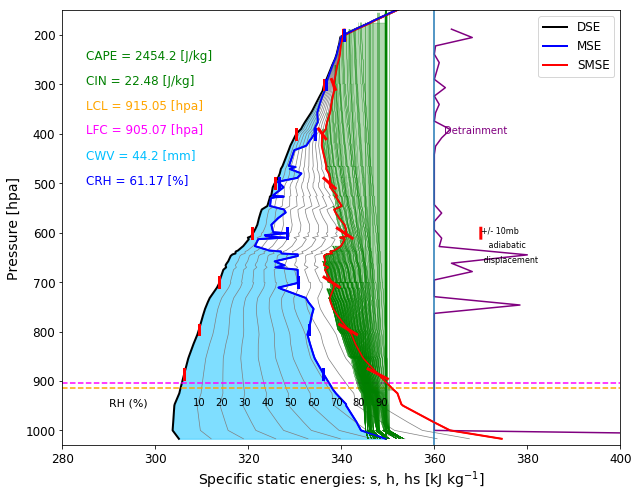

In [103]:
msed_plots(pressure,Temp,q,entrain=True) # altitude included

surface mse =  349.55399047379416 kilojoule / kilogram


<module 'matplotlib.pyplot' from '/Users/willytsai/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

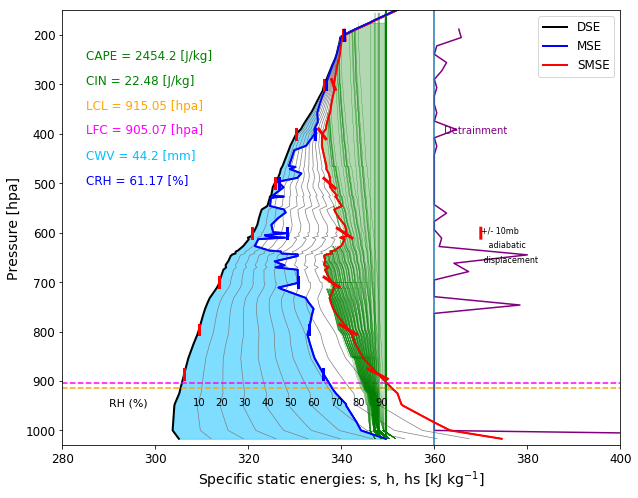

In [105]:
msed_plots(pressure,Temp,q,h0_std=2000,ensemble_size=10,entrain=True) # customize std for surface offset & ensembles

<module 'matplotlib.pyplot' from '/Users/willytsai/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

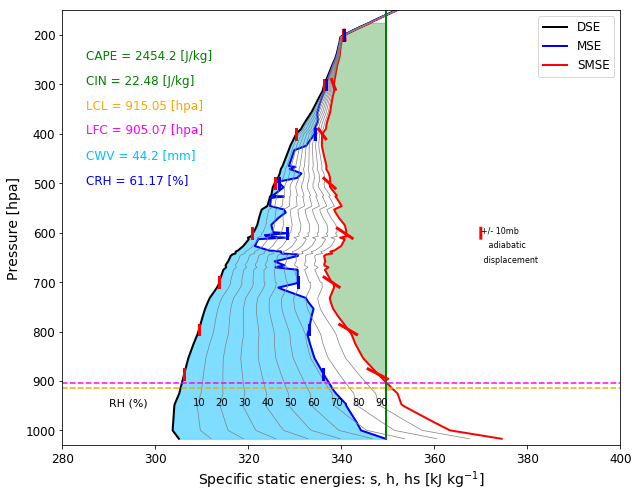

In [106]:
msed_plots(pressure,Temp,q,entrain=False) # altitude included